In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

2025-04-10 19:03:14.278746: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 19:03:14.307846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 19:03:14.752844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Defining the function:

In [2]:
def my_softmax(z):
    """ Softmax converts a vector of values to a probability distribution.

    Args:
      z (ndarray (N,))  : input data, N features
    Returns:
      sm (ndarray (N,))  : softmax of z    
    """

    ez = np.exp(z)
    sm = ez/np.sum(ez)
    return (sm)

Let's test this function:

In [3]:
z = np.array([1., 2., 3., 4.])
a = my_softmax(z)
atf = tf.nn.softmax(z)
print(f"my softmax(z):            {a}")
print(f"tensorflow softmax(z):    {atf}")

my softmax(z):            [0.0320586  0.08714432 0.23688282 0.64391426]
tensorflow softmax(z):    [0.0320586  0.08714432 0.23688282 0.64391426]


2025-04-10 19:03:15.441807: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-10 19:03:15.442054: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


I am going to build a neural network to recognize ten handwritten digits, 0-9.

In [4]:
def load_data():
    X = np.load("data/Data_Digit_Recognition_Multiclass/X.npy")
    y = np.load("data/Data_Digit_Recognition_Multiclass/y.npy")
    return X, y

In [5]:
X, y = load_data()

# Data Exploration

In [6]:
print("The first element of X is: ", X[0])

The first element of X is:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

In [7]:
print("The first element of y is: ", y[0,0])
print("The last element of y is: ", y[-1,0])

The first element of y is:  0
The last element of y is:  9


The dimensions of the variables:

In [8]:
print("The shape of X is: " + str(X.shape))
print("The shape of y is: " + str(y.shape))

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)


# Visualizing the data

In [9]:
def widgvis(fig):
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

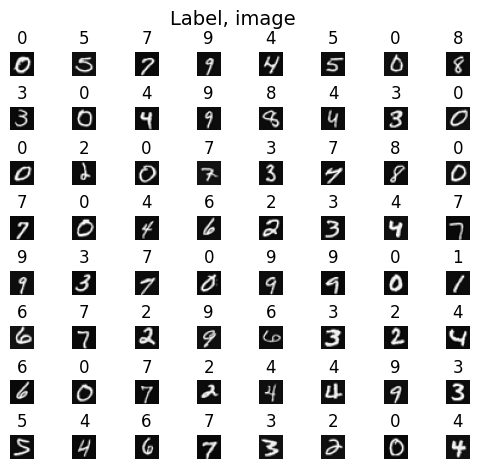

In [10]:
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)
#widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)

# Model

The images are of size 20x20. So, I have 400 inputs.
Furthermore, I have 2 dense layers with ReLU activations followed by an output layer with linear activation.

The parameters have dimensions that are sized for a neural network with 25 units in layer 1, 15 units in layer 2 and 10 ouput in layer 3, one for each digit.

Therefore, the shapes of `W` and `b`, are:
- Layer1: `W1` is (400,25), `b` is (25,)
- Layer2: `W1` is (25,15), `b` is (15,)
- Layer3: `W1` is (15,10), `b` is (10,)

Tensorflow utilizes a 1-D representation for the bias vector `b`. We will folllow this convention.


# Tensorflow Model

In [11]:
tf.random.set_seed(1234)
model = Sequential(
    [
        tf.keras.Input(shape=(400,)),
        Dense(25, activation='relu', name='layaer1'),
        Dense(15, activation='relu', name='layaer2'),
        Dense(10, activation='linear', name='layaer3'),
    ], name="my_model"
)

Let's examine teh weights:

In [12]:
[layer1, layer2, layer3] = model.layers

In [13]:
W1, b1 = layer1.get_weights()
W2, b2 = layer2.get_weights()
W3, b3 = layer3.get_weights()
print(f"W1 shape: {W1.shape}, b1 shape: {b1.shape}")
print(f"W2 shape: {W2.shape}, b2 shape: {b2.shape}")
print(f"W3 shape: {W3.shape}, b1 shape: {b3.shape}")

W1 shape: (400, 25), b1 shape: (25,)
W2 shape: (25, 15), b2 shape: (15,)
W3 shape: (15, 10), b1 shape: (10,)


# Loss function

In [14]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,y, epochs=40
)

Epoch 1/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - loss: 1.9147 
Epoch 2/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 0.6223
Epoch 3/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 0.4175
Epoch 4/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.3418
Epoch 5/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.2982
Epoch 6/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 0.2682
Epoch 7/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 0.2457
Epoch 8/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 0.2278
Epoch 9/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 0.2128
Epoch 10/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 0.1994
Epoch 11/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 0.1879
Epoch 12/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.1775
Epoch 13/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 0.1677
Epoch 14/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 0.1591
Epoch 15/40
157/157 ━━━━━━━━

In [15]:
def plot_loss_tf(history):
    fig,ax = plt.subplots(1,1, figsize = (4,3))
    #widgvis(fig)
    ax.plot(history.history['loss'], label='loss')
    ax.set_ylim([0, 2])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('loss (cost)')
    ax.legend()
    ax.grid(True)
    plt.show()

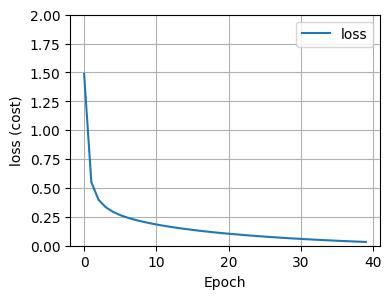

In [16]:
plot_loss_tf(history)

# Prediction

In [17]:
image_of_two = X[1015]

In [26]:
def display_digit():
    fig, ax = plt.subplots(1,1, figsize=(1,1))
    image_of_two_reshaped = image_of_two.reshape((20,20)).T
    ax.imshow(image_of_two_reshaped, cmap='gray')
    plt.show()

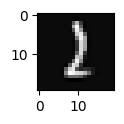

In [27]:
display_digit()

In [28]:
prediction = model.predict(image_of_two.reshape(1,400))

print(f" Predicting a two: \n{prediction}")
print(f" Largest prediction index: {np.argmax(prediction)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 Predicting a two: 
[[-11.342517    3.742273    6.4698586   3.282991   -6.618673   -7.4078264
   -7.359627    2.7844903  -2.6858776  -8.922063 ]]
 Largest prediction index: 2


The largest output is prediction[2], indicating the prediction digit is "2". Converting into probability:

In [31]:
prediction_p = tf.nn.softmax(prediction)

print(f" Predicting a two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")

 Predicting a two. Probability vector: 
[[1.6232473e-08 5.7759833e-02 8.8348931e-01 3.6489025e-02 1.8277815e-06
  8.3023122e-07 8.7122896e-07 2.2164920e-02 9.3307302e-05 1.8263100e-07]]
Total of predictions: 1.000


To return an integer representing the predicted target, you want the index of the largest probability:

In [32]:
yhat = np.argmax(prediction_p)
print(f"np.argmax(prediction_p): {yhat}")

np.argmax(prediction_p): 2


Let's compare the predictions vs labels for a random sample of 64 digits:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━

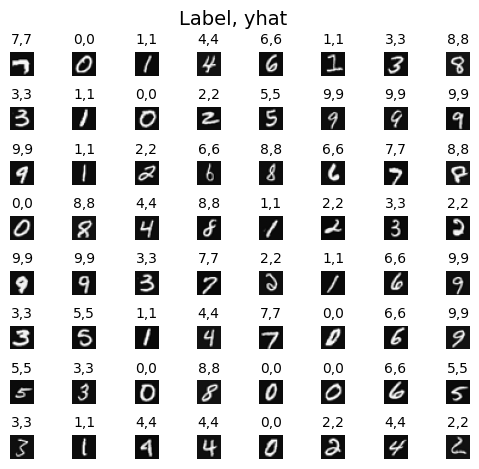

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}",fontsize=10)
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=14)
plt.show()